In [835]:
import numpy as np
import matplotlib.pyplot as plt

In [836]:
x_start = 0
x_end = 1
N = 25
dx = (x_end-x_start)/N
CFL = 0.5
R = 8.31
gamma = 1.4
M = 50

In [837]:
# WENO3
# 1 фиктивныx узла на границе, фактических !границ! N+1
N_fict = 1
N_all = N + 2*N_fict

# выделение памяти
U = np.zeros((5, N_all), dtype = 'float128')
F = np.zeros((5, N+1), dtype = 'float128')
U_hist = np.zeros((M, 5, N_all), dtype = 'float128')

# начальные условия, сетка
u0 = 1.0
T0 = 0.1
rho0 = 1
p0 = R*T0*rho0
x = np.linspace(x_start-N_fict*dx, x_end+N_fict*dx, num = N_all+1)
for i in range(N_all):
    U[0, i] = rho0 # + x[i]*(1.0 - x[i])
    U[1, i] = U[0, i] * u0
    U[2, i] = 0
    U[3, i] = 0
    U[4, i] = p0/(gamma - 1) + U[0, i]*(u0**2)/2

# считаем
t = 0
for j in range(M):
    # граничные условия
    # IN
    rho_i = U[4, N_fict] - (U[1, N_fict]**2)/U[0, N_fict]/2.0
    # print("rho_i", rho_i)
    # print(rho_i*(gamma - 1))
    a = (rho_i*(gamma - 1.0)*gamma/U[0, N_fict])**0.5
    bound_p = (gamma - 1.0)*rho_i + (a*U[0, N_fict])*(u0 - U[1, N_fict]/U[0, N_fict])
    bound_rho = bound_p/R/T0
    # print("rho", bound_rho)
    # print("a", a)
    bound_e = (T0*R)/(gamma - 1) + (u0**2)/2.
    # print("e", bound_e)
    for i in range(N_fict):
        a = -1
        b = 2
        U[0, i] = a*U[0, N_fict] + b*bound_rho
        U[1, i] = a*U[1, N_fict] + b*u0*bound_rho
        U[2, i] = a*U[2, N_fict] + b*0*bound_rho
        U[3, i] = a*U[3, N_fict] + b*0*bound_rho
        U[4, i] = a*U[4, N_fict] + b*bound_e*bound_rho
    F[0, 0] = bound_rho*u0
    F[1, 0] = bound_rho*u0**2 + bound_p
    F[2, 0] = bound_rho*0*u0
    F[3, 0] = bound_rho*0*u0
    F[4, 0] = gamma*bound_rho*u0*bound_e - (gamma-1)*bound_rho*(u0**3)/2.0
    # OUT
    intern = N_all-N_fict-1
    rho_i = U[4, intern] - (U[1, intern]**2)/U[0, intern]/2.0
    a = ((rho_i*(gamma - 1.0)*gamma/U[0, intern]))**0.5
    dp = p0 - (gamma - 1.0)*rho_i
    bound_v = U[2, intern]/U[0, intern]
    bound_w = U[3, intern]/U[0, intern]
    bound_u = U[1, intern]/U[0, intern] - dp/(a*U[0, intern]);
    bound_rho = U[0, intern] + dp/(a**2)
    bound_e = bound_p/(gamma - 1.0)/bound_rho + (bound_u**2)/2.0
    for i in range(N_fict):
        U[0, N_all-i-1] = -U[0, intern] + 2*bound_rho
        U[1, N_all-i-1] = -U[1, intern] + 2*bound_u*bound_rho
        U[2, N_all-i-1] = -U[2, intern] + 2*bound_v*bound_rho
        U[3, N_all-i-1] = -U[3, intern] + 2*bound_w*bound_rho
        U[4, N_all-i-1] = -U[4, intern] + 2*bound_e*bound_rho
    F[0, N] = bound_rho*bound_u
    F[1, N] = bound_rho*bound_u*bound_u + p0
    F[2, N] = bound_rho*bound_v*bound_u
    F[3, N] = bound_rho*bound_w*bound_u
    F[4, N] = gamma*bound_rho*bound_u*bound_e - (gamma-1)*bound_rho*(bound_u**3)/2.0
    # шаг по времени
    dt = 10
    dt_temp = dt
    for i in range(N_all):
        if U[1, i] != 0:
            dt_temp = abs(CFL*dx*U[0, i]/U[1, i])
            if dt_temp < dt:
                dt = dt_temp
    # print("dt", dt)
    # U_left и U_right
    t += dt
    U_left = np.zeros((5, N_all))
    U_right = np.zeros((5, N_all))
    for l in range(5):
        c0 = U[l, :]
        # WENO3 реконструкция поехли
        # 1 - левый 0 - правый 2(-1) - суперправый
        h0 = np.zeros(N+1)
        h1 = np.zeros(N+1)
        h2 = np.zeros(N+1)
        h_temp = [h2, h0, h1]
        hl  = U_left[l]
        hr  = U_right[l]
        eps = 1e-40
        alpha = np.zeros(2)
        omega = np.zeros(2)
        gamma = np.array([1/3, 2/3]) # стр. 112
        beta  = np.zeros(2)
        for i in range(1, N):
            # лекция
            i_temp = i + N_fict - 1 # отступ на фиктивные
            h0[i] =  1/2*c0[i_temp]   + 1/2*c0[i_temp+1]
            h1[i] = -1/2*c0[i_temp-1] + 3/2*c0[i_temp]
            h2[i] =  3/2*c0[i_temp+1] - 1/2*c0[i_temp+2]
            # лекция
            beta[0] = (c0[i_temp+1] - c0[i_temp])**2
            beta[1] = (c0[i_temp]   - c0[i_temp-1])**2
            # hl == u_left
            for k in range(2):
                alpha[k] = (eps+beta[k])**2
                alpha[k] = gamma[k]/alpha[k]
            for k in range(2):
                omega[k] = alpha[k]/(sum(alpha))
                hl[i] += omega[k]*h_temp[k+1][i]
            # hr == u_right
            beta[0] = (c0[i_temp+2] - c0[i_temp+1])**2
            beta[1] = (c0[i_temp+1]   - c0[i_temp])**2
            for k in range(2):
                alpha[k] = (eps+beta[k])**2
                alpha[k] = gamma[1-k]/alpha[k]
            for k in range(2):
                omega[k] = alpha[k]/(sum(alpha))
                hr[i] += omega[k]*h_temp[k][i]
    
    # потоки
    gamma = 1.4
    for i in range(1, N):
        F[0, i] = U_left[1, i]
        F[1, i] = (U_left[1, i]**2)/U_left[0, i] + (gamma - 1)*(U_left[4, i] - (U_left[1, i]**2)/U_left[0, i]/2.0)
        F[2, i] = U_left[2, i]*U_left[1, i]/U[0, i]
        F[3, i] = U_left[3, i]*U_left[1, i]/U[0, i]
        F[4, i] = gamma*U_left[1, i]*U_left[4, i]/U_left[0, i] - (gamma - 1)*((U_left[1, i]**3)/(U_left[0, i]**2)/2.0)
    
    # print(F)
    # подставляем потоки в схему
    for k in range(5):
        for i in range(N):
            i_temp = i + N_fict
            U[k, i_temp] -= round((F[k, i+1] - F[k, i])*dt/dx, 12)
            
    U_hist[j, :, :] = U

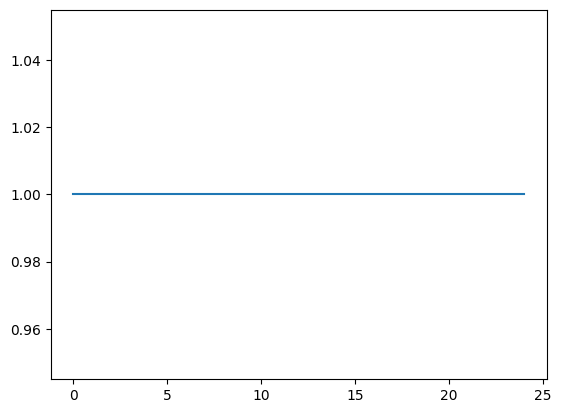

In [838]:
plt.plot(U_hist[25, 0, N_fict:N+N_fict])
plt.show()